<a href="https://colab.research.google.com/github/barretotiago/project_ML/blob/main/Final_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and load libraries



In [33]:
!pip install wandb
!pip install sklearn
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [35]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##Holdout Configuration

In [36]:
# global variables

# ratio used to split train and test data
val_size = 0.30

# seed used to reproduce purposes
seed = 90

# reference (column) to stratify the data
stratify = "assessment"

# name of the input artifact
artifact_input_name = "decision_tree/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [37]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="decision_tree",job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Creating the target variable")

df_train['target'] = np.where(df_train['assessment']=='unacc', 0, 1)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


25-07-2022 20:49:01 Downloading and reading train artifact
25-07-2022 20:49:02 Creating the target variable


In [6]:
df_train.head()

,buying,maint,doors,persons,lug_boot,safety,assessment,target
0,med,med,3,4,small,high,acc,1
1,high,high,2,2,med,med,unacc,0
2,high,low,2,4,small,high,acc,1
3,med,low,5more,more,med,high,vgood,1
4,high,low,2,2,med,med,unacc,0


In [38]:
# Split data into Train and Validation
print(len(df_train))

train, val = np.split(df_train.sample(frac=1), [int((1.-val_size)*len(df_train))])
print(len(train), 'train examples')
print(len(val), 'validation examples')

# Create a tf.data dataset from a Panda Dataset

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

1209
846 train examples
363 validation examples


In [39]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


In [40]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
#print('A batch of page_rank:', train_features['page_rank'])
print('A batch of status:', label_batch)

Every feature: ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'assessment']
A batch of status: tf.Tensor([1 0 0 1 1], shape=(5,), dtype=int64)


##Data preparation

In [41]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [42]:
categorical_cols = ['buying', 'maint',	'doors',	'persons',	'lug_boot',	'safety']

In [43]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
#test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


In [44]:
all_inputs = []
encoded_features = []

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=6)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

### Create, compile and train the model

In [45]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [47]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['assessment'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


4/4 [==============================] - 1s 158ms/step - loss: 0.7409 - accuracy: 0.5993 - val_loss: 0.6961 - val_accuracy: 0.7052
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 0.7345 - accuracy: 0.6300 - val_loss: 0.6743 - val_accuracy: 0.7163
Epoch 3/10
4/4 [==============================] - 0s 21ms/step - loss: 0.6938 - accuracy: 0.6537 - val_loss: 0.6550 - val_accuracy: 0.7163
Epoch 4/10
4/4 [==============================] - 0s 18ms/step - loss: 0.6871 - accuracy: 0.6690 - val_loss: 0.6378 - val_accuracy: 0.7163
Epoch 5/10
4/4 [==============================] - 0s 17ms/step - loss: 0.6741 - accuracy: 0.6773 - val_loss: 0.6222 - val_accuracy: 0.7163
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 0.6503 - accuracy: 0.6785 - val_loss: 0.6083 - val_accuracy: 0.7163
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 0.6507 - accuracy: 0.6903 - val_loss: 0.5954 - val_accuracy: 0.7163
Epoch 8/10
4/4 [=====================

##Hyperparamenter Tuning and Better Training/Better Generalization

In [48]:
# global seed
seed = 57

In [49]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [50]:
# Defining Functions
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer   

In [51]:
# Initialize from scratch

# Read TRAIN data ==============================================================

#ratio used to split traind and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 57

# reference (column) to stratify the data
stratify = "assessment"

# name of the imput artifact
artifact_input_name = "decision_tree/train.csv:latest"

# type of the artifact
artifact_type = "Train"

# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S")

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="decision_tree",job_type="train")

logger.info("Downloading and reading the train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Creating the target variable")

df_train['target'] = np.where(df_train[stratify]=='unacc', 0, 1)



# Split data into Train and Validation =========================================

train, val = np.split(df_train.sample(frac=1), [int((1.-val_size)*len(df_train))])
logger.info("Train Samples:", len(train))
logger.info("Validation Samples:", len(val))

# Downloading Test Artifact ====================================================

logger.info("Downloading and reading the test artifact")
artifact_input_name = "decision_tree/train.csv:latest"

local_path = run.use_artifact(artifact_input_name).file()
df_test = pd.read_csv(local_path)

df_test['target'] = np.where(df_test[stratify]=='unacc', 0, 1)

test_ds = df_to_dataset(df_test)
logger.info("Test Samples:", len(df_test))


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


25-07-2022 20:50:14 Downloading and reading the train artifact
25-07-2022 20:50:15 Creating the target variable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-pack

In [52]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Test Accuracy",
        "goal" : "maximize"
    },
    "parameters": {
        # Nodes per hidden layer
        "nodes": {
            "values": [22, 44, 87, 174]
        },
        # Hidden Layers
        "layers": {
            "values": [1, 2, 3, 4]
        },
        # Batch Size
        "batch_size": {
            "values": [230, 570, 1143, 2286]
        },
        # Loss Function
        "criterion": {
            "values": ["BinaryCrossentropy", "MeanSquaredError"]
        },
        "optimizer": {
            "values": ["sgd", "adam", "rmsprop", "adagrad"]
        },
        # SGD Learning Rate
        "learning_rate": {
            "values": [0.01, 0.05, 0.1]
        },
        # SGD Momentum
        "momentum": {
            "values": [0.9]
        },
        # L2 vs Dropout
        "overfit_preventing": {
            "values": ["l2", "dropout", "weight_cons"]
        },
        # Node Dropout
        "dropout": {
            "values": [0.2, 0.4]
        },
        # Weights Initializer
        "initializer": {
            "values": ['zeros', 'random']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="decision_tree")

Create sweep with ID: 4mxs3icc
Sweep URL: https://wandb.ai/tiagobarreto/decision_tree/sweeps/4mxs3icc


In [53]:
def train_func():
    with wandb.init() as run:
        # Building the Dataset -------------------------------------------------
        logger.info('Creating Datasets')
        batch_size = 250
        train_ds = df_to_dataset(train, batch_size=batch_size)
        val_ds = df_to_dataset(val, batch_size=batch_size)
        test_ds = df_to_dataset(df_test, batch_size=batch_size)

        # Creating the Input Preprocessor --------------------------------------
        logger.info('Creating Preprocessors')
        all_inputs = []
        encoded_features = []

        numerical_features = train.select_dtypes(["int64","float"]).columns.to_list()
        numerical_features.pop() # Remove ['target']

        for header in categorical_cols:
          categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
          encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=6)
          encoded_categorical_col = encoding_layer(categorical_col)
          all_inputs.append(categorical_col)
          encoded_features.append(encoded_categorical_col)

        # Create, compile and train the model ----------------------------------
        logger.info('Creating and Compiling the Model')
        all_features = tf.keras.layers.concatenate(encoded_features)

        x = tf.keras.layers.Dense(87,activation='tanh')(all_features)

        for i in range(0, run.config.layers):
        
            init = None

            if run.config.initializer == "random":
                init = tf.keras.initializers.RandomNormal(mean=0,stddev=1)
            elif run.config.initializer == "zeros":
                init = tf.keras.initializers.Zeros()

            if run.config.overfit_preventing == "l2":
                x = tf.keras.layers.Dense(run.config.nodes,
                                          activation='tanh',
                                          kernel_regularizer=l2(0.001),
                                          kernel_initializer=init)(x)
            elif run.config.overfit_preventing == "dropout":
                x = tf.keras.layers.Dense(run.config.nodes,
                                          activation='tanh',
                                          kernel_initializer=init)(x)
                x = tf.keras.layers.Dropout(run.config.dropout)(x)
            elif run.config.overfit_preventing == "weight_cons":
                x = tf.keras.layers.Dense(run.config.nodes,
                                          activation='tanh',
                                          kernel_constraint=unit_norm())(x)

        output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

        model = tf.keras.Model(all_inputs, output)

        lf = None

        if run.config.criterion == "BinaryCrossentropy":
            lf = tf.keras.losses.BinaryCrossentropy()
        elif run.config.criterion == "MeanSquaredError":
            lf = tf.keras.losses.MeanSquaredError()
        
        # Optimizers -----------------------------------------------------------
        opt = run.config.optimizer
        if opt == "sgd": 
            opt = SGD(learning_rate=run.config.learning_rate, momentum=run.config.momentum)
        
        model.compile(loss=lf, metrics=["accuracy"], optimizer=opt)

        # Trainning ------------------------------------------------------------
        es = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)
        logger.info('Trainning')
        history = model.fit(train_ds,
                            epochs=200,
                            validation_data=val_ds,
                            verbose=0,
                            batch_size=run.config.batch_size,
                            callbacks=[es]
                            )

        # Predict --------------------------------------------------------------
        logger.info("Infering")
        _, train_acc = model.evaluate(train_ds, verbose=0)
        _, val_acc = model.evaluate(val_ds, verbose=0)
        _, test_acc = model.evaluate(test_ds, verbose=0)

        # Creating Figures -----------------------------------------------------
        logger.info("Creating Figures")
        fig, ax = plt.subplots(1,2, figsize=(10,4))

        ax[0].set_title((run.config.criterion + " Loss"), pad=-40)
        ax[0].plot(history.history['loss'], label='train')
        ax[0].plot(history.history['val_loss'], label='val')
        ax[0].legend(loc='best')

        ax[1].set_title(("Accuracy"), pad=-40)
        ax[1].plot(history.history['accuracy'], label='train')
        ax[1].plot(history.history['val_accuracy'], label='val')
        ax[1].legend(loc='best')

        plt.show()
        logger.info("Train Accuracy: {}".format(train_acc))
        logger.info("Val Accuracy: {}".format(val_acc))
        logger.info("Test Accuracy: {}".format(test_acc))

        run.summary["Train Accuracy"] = train_acc
        run.summary["Val Accuracy"] = val_acc
        run.summary["Test Accuracy"] = test_acc

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: a43ftme2 with config:
wandb: 	batch_size: 230
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 3
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.9
wandb: 	nodes: 22
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: dropout


25-07-2022 20:50:45 Creating Datasets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
25-07-2022 20:50:45 Creating Preprocessors
25-07-2022 20:50:46 Creating and Compiling the Model
25-07-2022 20:50:46 Trainning
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['assessment'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
25-07-2022 20:50:58 Infering
25-07-2022 20:50:58 Creating Figures


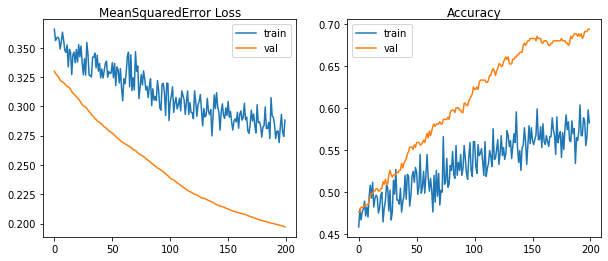

25-07-2022 20:50:58 Train Accuracy: 0.6666666865348816
25-07-2022 20:50:58 Val Accuracy: 0.6942148804664612
25-07-2022 20:50:58 Test Accuracy: 0.6749379634857178


Test Accuracy,0.67494
Train Accuracy,0.66667
Val Accuracy,0.69421


wandb: Agent Starting Run: 27k1wq9f with config:
wandb: 	batch_size: 230
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.2
wandb: 	initializer: zeros
wandb: 	layers: 1
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 44
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: dropout


25-07-2022 20:51:12 Creating Datasets
25-07-2022 20:51:12 Creating Preprocessors
25-07-2022 20:51:13 Creating and Compiling the Model
25-07-2022 20:51:13 Trainning
25-07-2022 20:51:25 Infering
25-07-2022 20:51:25 Creating Figures


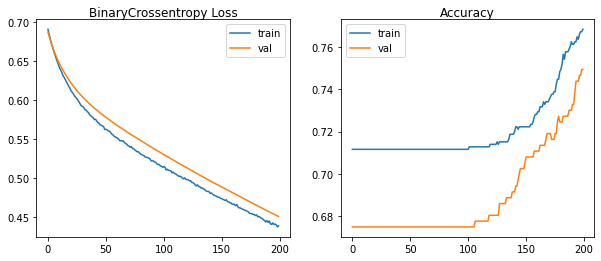

25-07-2022 20:51:26 Train Accuracy: 0.7671394944190979
25-07-2022 20:51:26 Val Accuracy: 0.7493112683296204
25-07-2022 20:51:26 Test Accuracy: 0.7617865800857544


Test Accuracy,0.76179
Train Accuracy,0.76714
Val Accuracy,0.74931


wandb: Agent Starting Run: nfy8ix9q with config:
wandb: 	batch_size: 2286
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 3
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 44
wandb: 	optimizer: adam
wandb: 	overfit_preventing: dropout


25-07-2022 20:51:39 Creating Datasets
25-07-2022 20:51:39 Creating Preprocessors
25-07-2022 20:51:39 Creating and Compiling the Model
25-07-2022 20:51:39 Trainning


Epoch 118: early stopping


25-07-2022 20:51:47 Infering
25-07-2022 20:51:47 Creating Figures


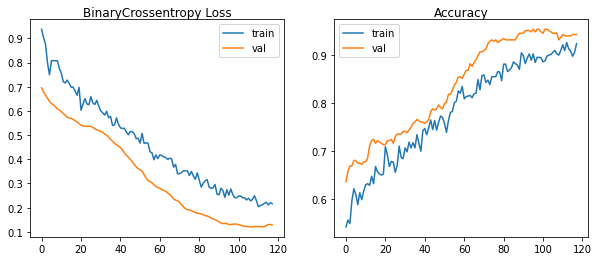

25-07-2022 20:51:48 Train Accuracy: 0.9751772880554199
25-07-2022 20:51:48 Val Accuracy: 0.942148745059967
25-07-2022 20:51:48 Test Accuracy: 0.9652605652809143


Test Accuracy,0.96526
Train Accuracy,0.97518
Val Accuracy,0.94215


wandb: Agent Starting Run: k1xpxawr with config:
wandb: 	batch_size: 2286
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.4
wandb: 	initializer: zeros
wandb: 	layers: 2
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.9
wandb: 	nodes: 174
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: l2


25-07-2022 20:52:00 Creating Datasets
25-07-2022 20:52:00 Creating Preprocessors
25-07-2022 20:52:01 Creating and Compiling the Model
25-07-2022 20:52:01 Trainning
25-07-2022 20:52:14 Infering
25-07-2022 20:52:14 Creating Figures


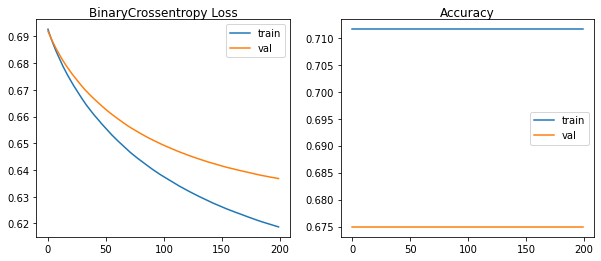

25-07-2022 20:52:14 Train Accuracy: 0.7115839123725891
25-07-2022 20:52:14 Val Accuracy: 0.6749311089515686
25-07-2022 20:52:14 Test Accuracy: 0.7005789875984192


Test Accuracy,0.70058
Train Accuracy,0.71158
Val Accuracy,0.67493


wandb: Agent Starting Run: r32q3wea with config:
wandb: 	batch_size: 230
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 3
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 22
wandb: 	optimizer: adam
wandb: 	overfit_preventing: dropout


25-07-2022 20:52:27 Creating Datasets
25-07-2022 20:52:27 Creating Preprocessors
25-07-2022 20:52:27 Creating and Compiling the Model
25-07-2022 20:52:27 Trainning


Epoch 21: early stopping


25-07-2022 20:52:30 Infering
25-07-2022 20:52:31 Creating Figures


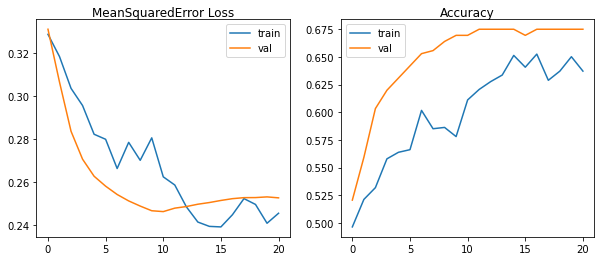

25-07-2022 20:52:31 Train Accuracy: 0.7104018926620483
25-07-2022 20:52:31 Val Accuracy: 0.6749311089515686
25-07-2022 20:52:31 Test Accuracy: 0.6997518539428711


Test Accuracy,0.69975
Train Accuracy,0.7104
Val Accuracy,0.67493


wandb: Agent Starting Run: p53230vg with config:
wandb: 	batch_size: 230
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.2
wandb: 	initializer: random
wandb: 	layers: 3
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 22
wandb: 	optimizer: rmsprop
wandb: 	overfit_preventing: l2


25-07-2022 20:52:43 Creating Datasets
25-07-2022 20:52:43 Creating Preprocessors
25-07-2022 20:52:44 Creating and Compiling the Model
25-07-2022 20:52:44 Trainning
25-07-2022 20:52:57 Infering
25-07-2022 20:52:57 Creating Figures


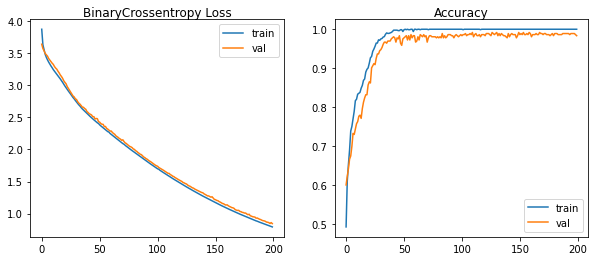

25-07-2022 20:52:57 Train Accuracy: 1.0
25-07-2022 20:52:57 Val Accuracy: 0.9834710955619812
25-07-2022 20:52:57 Test Accuracy: 0.9950371980667114


Test Accuracy,0.99504
Train Accuracy,1.0
Val Accuracy,0.98347


wandb: Agent Starting Run: 4xca8r2d with config:
wandb: 	batch_size: 230
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 4
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 44
wandb: 	optimizer: adam
wandb: 	overfit_preventing: weight_cons


25-07-2022 20:53:11 Creating Datasets
25-07-2022 20:53:11 Creating Preprocessors
25-07-2022 20:53:11 Creating and Compiling the Model
25-07-2022 20:53:11 Trainning


Epoch 29: early stopping


25-07-2022 20:53:15 Infering
25-07-2022 20:53:15 Creating Figures


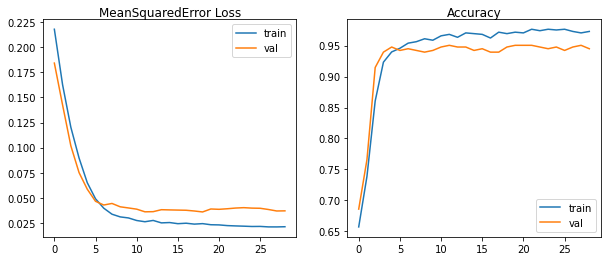

25-07-2022 20:53:16 Train Accuracy: 0.9739952683448792
25-07-2022 20:53:16 Val Accuracy: 0.944903552532196
25-07-2022 20:53:16 Test Accuracy: 0.9652605652809143


Test Accuracy,0.96526
Train Accuracy,0.974
Val Accuracy,0.9449


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 79jq02v2 with config:
wandb: 	batch_size: 1143
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.2
wandb: 	initializer: zeros
wandb: 	layers: 4
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	nodes: 22
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: l2


25-07-2022 20:53:37 Creating Datasets
25-07-2022 20:53:37 Creating Preprocessors
25-07-2022 20:53:37 Creating and Compiling the Model
25-07-2022 20:53:38 Trainning
25-07-2022 20:53:51 Infering
25-07-2022 20:53:51 Creating Figures


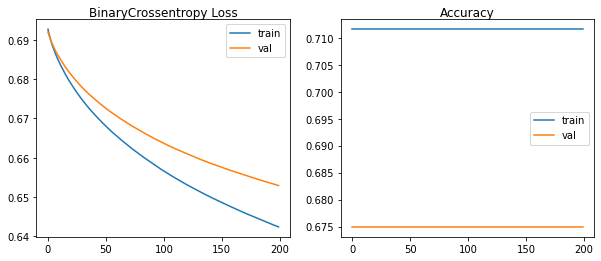

25-07-2022 20:53:51 Train Accuracy: 0.7115839123725891
25-07-2022 20:53:51 Val Accuracy: 0.6749311089515686
25-07-2022 20:53:51 Test Accuracy: 0.7005789875984192


Test Accuracy,0.70058
Train Accuracy,0.71158
Val Accuracy,0.67493


wandb: Agent Starting Run: 5rgi8prj with config:
wandb: 	batch_size: 2286
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.4
wandb: 	initializer: zeros
wandb: 	layers: 2
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 44
wandb: 	optimizer: adam
wandb: 	overfit_preventing: l2


25-07-2022 20:54:05 Creating Datasets
25-07-2022 20:54:05 Creating Preprocessors
25-07-2022 20:54:05 Creating and Compiling the Model
25-07-2022 20:54:05 Trainning


Epoch 27: early stopping


25-07-2022 20:54:09 Infering
25-07-2022 20:54:09 Creating Figures


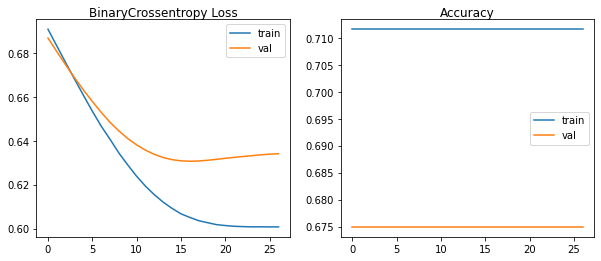

25-07-2022 20:54:09 Train Accuracy: 0.7115839123725891
25-07-2022 20:54:09 Val Accuracy: 0.6749311089515686
25-07-2022 20:54:09 Test Accuracy: 0.7005789875984192


Test Accuracy,0.70058
Train Accuracy,0.71158
Val Accuracy,0.67493


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 635npxjj with config:
wandb: 	batch_size: 230
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 4
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	nodes: 44
wandb: 	optimizer: rmsprop
wandb: 	overfit_preventing: l2


25-07-2022 20:54:36 Creating Datasets
25-07-2022 20:54:36 Creating Preprocessors
25-07-2022 20:54:37 Creating and Compiling the Model
25-07-2022 20:54:37 Trainning
25-07-2022 20:54:51 Infering
25-07-2022 20:54:52 Creating Figures


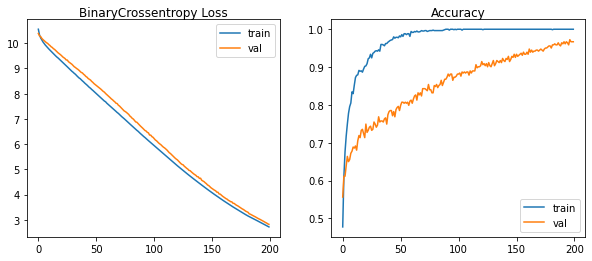

25-07-2022 20:54:52 Train Accuracy: 1.0
25-07-2022 20:54:52 Val Accuracy: 0.9669421315193176
25-07-2022 20:54:52 Test Accuracy: 0.9900744557380676


Test Accuracy,0.99007
Train Accuracy,1.0
Val Accuracy,0.96694


wandb: Agent Starting Run: dyjnrs7k with config:
wandb: 	batch_size: 1143
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.2
wandb: 	initializer: random
wandb: 	layers: 4
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	nodes: 174
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: dropout


25-07-2022 20:55:08 Creating Datasets
25-07-2022 20:55:08 Creating Preprocessors
25-07-2022 20:55:09 Creating and Compiling the Model
25-07-2022 20:55:09 Trainning
25-07-2022 20:55:33 Infering
25-07-2022 20:55:33 Creating Figures


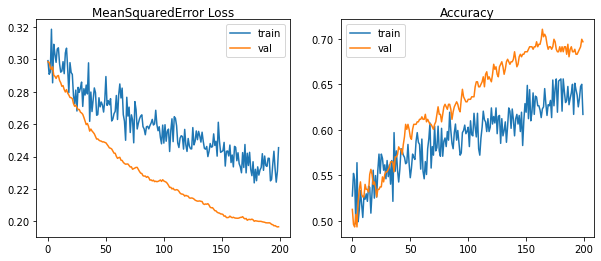

25-07-2022 20:55:33 Train Accuracy: 0.7127659320831299
25-07-2022 20:55:33 Val Accuracy: 0.6969696879386902
25-07-2022 20:55:33 Test Accuracy: 0.7080231308937073


Test Accuracy,0.70802
Train Accuracy,0.71277
Val Accuracy,0.69697


wandb: Agent Starting Run: 7z51q5ix with config:
wandb: 	batch_size: 1143
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.2
wandb: 	initializer: zeros
wandb: 	layers: 1
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 22
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: l2


25-07-2022 20:55:50 Creating Datasets
25-07-2022 20:55:50 Creating Preprocessors
25-07-2022 20:55:51 Creating and Compiling the Model
25-07-2022 20:55:51 Trainning
25-07-2022 20:56:03 Infering
25-07-2022 20:56:04 Creating Figures


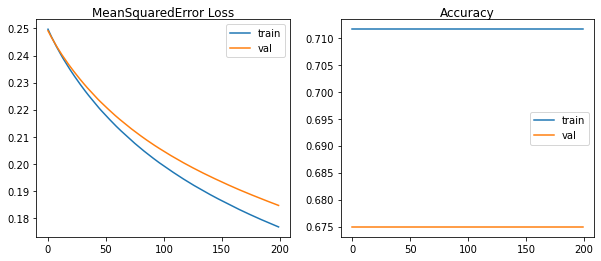

25-07-2022 20:56:04 Train Accuracy: 0.7115839123725891
25-07-2022 20:56:04 Val Accuracy: 0.6749311089515686
25-07-2022 20:56:04 Test Accuracy: 0.7005789875984192


Test Accuracy,0.70058
Train Accuracy,0.71158
Val Accuracy,0.67493


wandb: Agent Starting Run: 2by1mw2g with config:
wandb: 	batch_size: 1143
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.2
wandb: 	initializer: zeros
wandb: 	layers: 3
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.9
wandb: 	nodes: 87
wandb: 	optimizer: rmsprop
wandb: 	overfit_preventing: l2


25-07-2022 20:56:23 Creating Datasets
25-07-2022 20:56:23 Creating Preprocessors
25-07-2022 20:56:24 Creating and Compiling the Model
25-07-2022 20:56:24 Trainning


Epoch 21: early stopping


25-07-2022 20:56:27 Infering
25-07-2022 20:56:27 Creating Figures


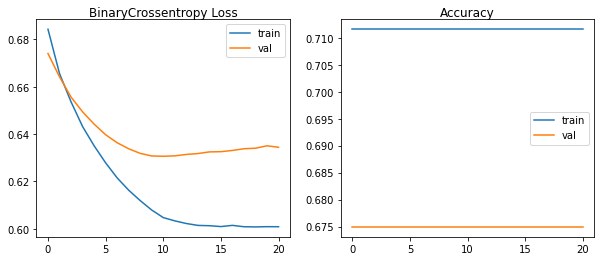

25-07-2022 20:56:27 Train Accuracy: 0.7115839123725891
25-07-2022 20:56:27 Val Accuracy: 0.6749311089515686
25-07-2022 20:56:27 Test Accuracy: 0.7005789875984192


Test Accuracy,0.70058
Train Accuracy,0.71158
Val Accuracy,0.67493


wandb: Agent Starting Run: 875rw65u with config:
wandb: 	batch_size: 1143
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 4
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	nodes: 174
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: dropout


25-07-2022 20:56:44 Creating Datasets
25-07-2022 20:56:44 Creating Preprocessors
25-07-2022 20:56:44 Creating and Compiling the Model
25-07-2022 20:56:45 Trainning


Epoch 39: early stopping


25-07-2022 20:56:51 Infering
25-07-2022 20:56:51 Creating Figures


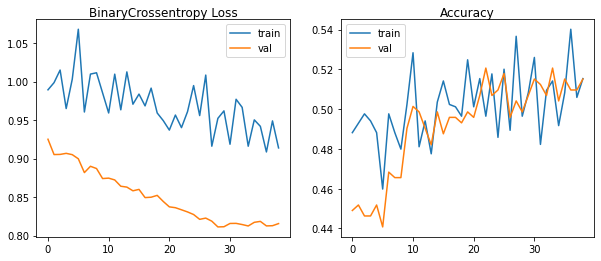

25-07-2022 20:56:52 Train Accuracy: 0.5508274435997009
25-07-2022 20:56:52 Val Accuracy: 0.5151515007019043
25-07-2022 20:56:52 Test Accuracy: 0.5401157736778259


Test Accuracy,0.54012
Train Accuracy,0.55083
Val Accuracy,0.51515


wandb: Agent Starting Run: gfxk9fue with config:
wandb: 	batch_size: 2286
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.2
wandb: 	initializer: random
wandb: 	layers: 3
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 22
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: weight_cons


25-07-2022 20:57:10 Creating Datasets
25-07-2022 20:57:10 Creating Preprocessors
25-07-2022 20:57:10 Creating and Compiling the Model
25-07-2022 20:57:10 Trainning
25-07-2022 20:57:22 Infering
25-07-2022 20:57:22 Creating Figures


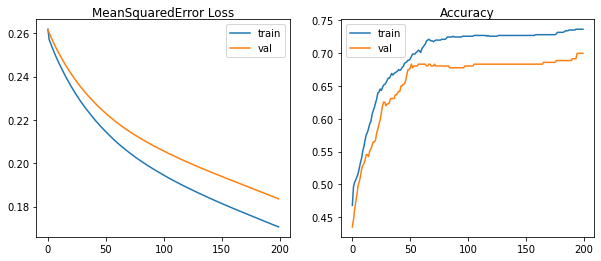

25-07-2022 20:57:23 Train Accuracy: 0.73758864402771
25-07-2022 20:57:23 Val Accuracy: 0.6997244954109192
25-07-2022 20:57:23 Test Accuracy: 0.7262200117111206


Test Accuracy,0.72622
Train Accuracy,0.73759
Val Accuracy,0.69972


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qlkm4l8i with config:
wandb: 	batch_size: 2286
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 4
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	nodes: 87
wandb: 	optimizer: adam
wandb: 	overfit_preventing: weight_cons


25-07-2022 20:57:47 Creating Datasets
25-07-2022 20:57:47 Creating Preprocessors
25-07-2022 20:57:47 Creating and Compiling the Model
25-07-2022 20:57:47 Trainning


Epoch 16: early stopping


25-07-2022 20:57:50 Infering
25-07-2022 20:57:50 Creating Figures


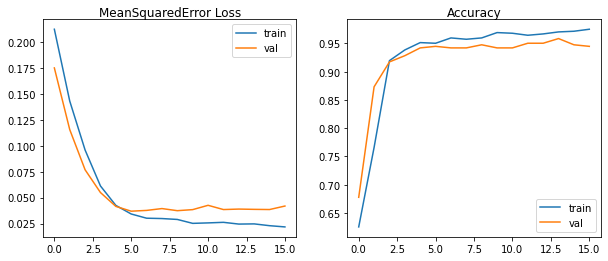

25-07-2022 20:57:51 Train Accuracy: 0.9716312289237976
25-07-2022 20:57:51 Val Accuracy: 0.944903552532196
25-07-2022 20:57:51 Test Accuracy: 0.9636062979698181


Test Accuracy,0.96361
Train Accuracy,0.97163
Val Accuracy,0.9449


wandb: Agent Starting Run: tzxubwsz with config:
wandb: 	batch_size: 1143
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.2
wandb: 	initializer: random
wandb: 	layers: 2
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 174
wandb: 	optimizer: sgd
wandb: 	overfit_preventing: weight_cons


25-07-2022 20:58:08 Creating Datasets
25-07-2022 20:58:09 Creating Preprocessors
25-07-2022 20:58:09 Creating and Compiling the Model
25-07-2022 20:58:09 Trainning


Epoch 31: early stopping


25-07-2022 20:58:13 Infering
25-07-2022 20:58:13 Creating Figures


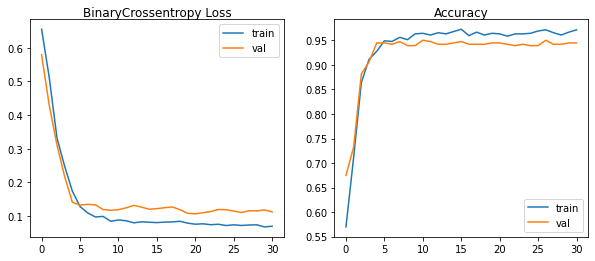

25-07-2022 20:58:14 Train Accuracy: 0.9728132486343384
25-07-2022 20:58:14 Val Accuracy: 0.944903552532196
25-07-2022 20:58:14 Test Accuracy: 0.9644334316253662


Test Accuracy,0.96443
Train Accuracy,0.97281
Val Accuracy,0.9449


wandb: Agent Starting Run: ghiw56pz with config:
wandb: 	batch_size: 230
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.2
wandb: 	initializer: random
wandb: 	layers: 1
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	nodes: 22
wandb: 	optimizer: adam
wandb: 	overfit_preventing: weight_cons


25-07-2022 20:58:30 Creating Datasets
25-07-2022 20:58:30 Creating Preprocessors
25-07-2022 20:58:31 Creating and Compiling the Model
25-07-2022 20:58:31 Trainning


Epoch 125: early stopping


25-07-2022 20:58:40 Infering
25-07-2022 20:58:40 Creating Figures


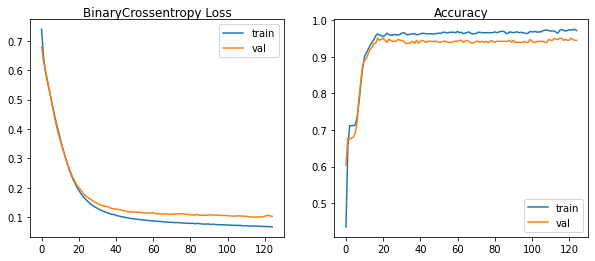

25-07-2022 20:58:41 Train Accuracy: 0.9728132486343384
25-07-2022 20:58:41 Val Accuracy: 0.944903552532196
25-07-2022 20:58:41 Test Accuracy: 0.9644334316253662


Test Accuracy,0.96443
Train Accuracy,0.97281
Val Accuracy,0.9449


wandb: Agent Starting Run: 06izzdjn with config:
wandb: 	batch_size: 230
wandb: 	criterion: MeanSquaredError
wandb: 	dropout: 0.4
wandb: 	initializer: zeros
wandb: 	layers: 3
wandb: 	learning_rate: 0.05
wandb: 	momentum: 0.9
wandb: 	nodes: 44
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: l2


25-07-2022 20:59:01 Creating Datasets
25-07-2022 20:59:01 Creating Preprocessors
25-07-2022 20:59:02 Creating and Compiling the Model
25-07-2022 20:59:02 Trainning
25-07-2022 20:59:16 Infering
25-07-2022 20:59:16 Creating Figures


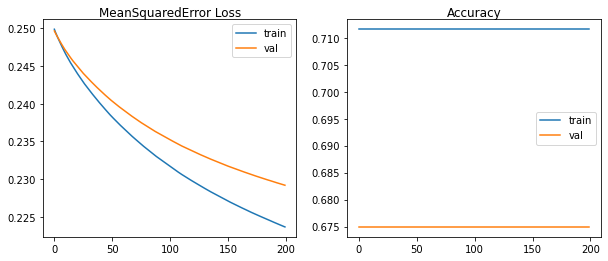

25-07-2022 20:59:16 Train Accuracy: 0.7115839123725891
25-07-2022 20:59:16 Val Accuracy: 0.6749311089515686
25-07-2022 20:59:16 Test Accuracy: 0.7005789875984192


Test Accuracy,0.70058
Train Accuracy,0.71158
Val Accuracy,0.67493


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xs2c6mby with config:
wandb: 	batch_size: 1143
wandb: 	criterion: BinaryCrossentropy
wandb: 	dropout: 0.4
wandb: 	initializer: random
wandb: 	layers: 2
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	nodes: 174
wandb: 	optimizer: adagrad
wandb: 	overfit_preventing: weight_cons


25-07-2022 20:59:43 Creating Datasets
25-07-2022 20:59:43 Creating Preprocessors
25-07-2022 20:59:43 Creating and Compiling the Model
25-07-2022 20:59:44 Trainning
25-07-2022 20:59:57 Infering
25-07-2022 20:59:57 Creating Figures


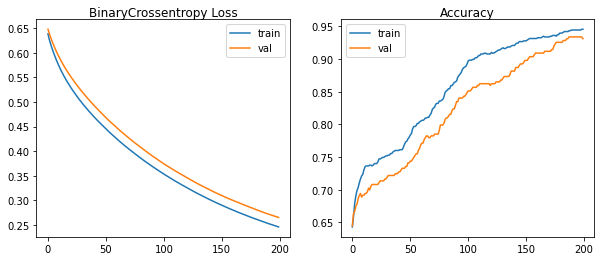

25-07-2022 20:59:57 Train Accuracy: 0.9456264972686768
25-07-2022 20:59:57 Val Accuracy: 0.9311294555664062
25-07-2022 20:59:58 Test Accuracy: 0.9412738084793091


Test Accuracy,0.94127
Train Accuracy,0.94563
Val Accuracy,0.93113


In [54]:
wandb.agent(sweep_id, train_func, count=20)

##Configure and train the best model

In [29]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [55]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [56]:
# Initialize from scratch

# Read TRAIN data ==============================================================

#ratio used to split traind and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 57

# reference (column) to stratify the data
stratify = "assessment"

# name of the imput artifact
artifact_input_name = "decision_tree/train.csv:latest"

# type of the artifact
artifact_type = "Train"

# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S")

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="decision_tree",job_type="train")

logger.info("Downloading and reading the train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Creating the target variable")

df_train['target'] = np.where(df_train[stratify]=='unacc', 0, 1)

#logger.info("Droping columns 'status' and 'url'")
#df_train = df_train.drop(columns=['status', 'url'])

# Split data into Train and Validation =========================================

train, val = np.split(df_train.sample(frac=1), [int((1.-val_size)*len(df_train))])
logger.info("Train Samples:", len(train))
logger.info("Validation Samples:", len(val))

# Downloading Test Artifact ====================================================

logger.info("Downloading and reading the test artifact")
artifact_input_name = "decision_tree/train.csv:latest"

local_path = run.use_artifact(artifact_input_name).file()
df_test = pd.read_csv(local_path)

df_test['target'] = np.where(df_test[stratify]=='unacc', 0, 1)

#logger.info("Droping columns 'status' and 'url'")
#df_test = df_test.drop(columns=['status', 'url'])

test_ds = df_to_dataset(df_test)
logger.info("Test Samples:", len(df_test))

logger.info('Creating Datasets')

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


25-07-2022 21:01:30 Downloading and reading the train artifact
25-07-2022 21:01:31 Creating the target variable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-pack

In [57]:
# Defining Functions
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
#print('A batch of page_rank:', train_features['page_rank'])
print('A batch of status:', label_batch)

def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = tf.keras.layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

categorical_cols = ['buying', 'maint',	'doors',	'persons',	'lug_boot',	'safety']

batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

Every feature: ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'assessment']
A batch of status: tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
25-07-2022 21:01:43 Creating Preprocessors
25-07-2022 21:01:43 Creating and Compiling the Model
25-07-2022 21:01:43 Trainning
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['assessment'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 161: early stopping


25-07-2022 21:01:58 Infering
25-07-2022 21:01:58 Creating Figures


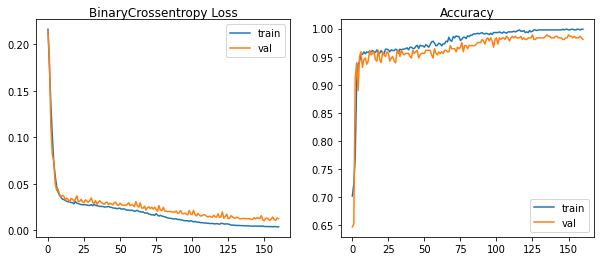

25-07-2022 21:01:59 Train Accuracy: 0.9988179802894592
25-07-2022 21:01:59 Val Accuracy: 0.9807162284851074
25-07-2022 21:01:59 Test Accuracy: 0.99338299036026


In [58]:
# Train Proccess ===============================================================

batch_size = 256
criterion="MeanSquaredError"
dropout=0.2
initializer="random"
layers=1
learning_rate=0.1
momentum=0.9
nodes=174
optimizer="sgd"
overfit_preventing="weight_cons"

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(df_test, batch_size=batch_size)

# Creating the Input Preprocessor --------------------------------------
logger.info('Creating Preprocessors')
all_inputs = []
encoded_features = []

#numerical_features = train.select_dtypes(["int64","float"]).columns.to_list()
#numerical_features.pop() # Remove ['target']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=6)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Create, compile and train the model ----------------------------------
logger.info('Creating and Compiling the Model')
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(87,activation='tanh')(all_features)

for i in range(0, layers):

    init = None

    if initializer == "random":
        init = tf.keras.initializers.RandomNormal(mean=0,stddev=1)
    elif initializer == "zeros":
        init = tf.keras.initializers.Zeros()

    if overfit_preventing == "l2":
        x = tf.keras.layers.Dense(run.config.nodes,
                                  activation='tanh',
                                  kernel_regularizer=l2(0.001),
                                  kernel_initializer=init)(x)
    elif overfit_preventing == "dropout":
        x = tf.keras.layers.Dense(run.config.nodes,
                                  activation='tanh',
                                  kernel_initializer=init)(x)
        x = tf.keras.layers.Dropout(run.config.dropout)(x)
    elif overfit_preventing == "weight_cons":
        x = tf.keras.layers.Dense(run.config.nodes,
                                  activation='tanh',
                                  kernel_constraint=unit_norm())(x)

output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)

lf = None

if criterion == "BinaryCrossentropy":
    lf = tf.keras.losses.BinaryCrossentropy()
elif criterion == "MeanSquaredError":
    lf = tf.keras.losses.MeanSquaredError()

# Optimizers -----------------------------------------------------------
opt = optimizer
if opt == "sgd": 
    opt = SGD(learning_rate=learning_rate, momentum=momentum)

model.compile(loss=lf, metrics=["accuracy"], optimizer=opt)

# Trainning ------------------------------------------------------------
es = EarlyStopping(monitor='val_loss',
                    mode='min',
                    verbose=1,
                    patience=10)
logger.info('Trainning')
history = model.fit(train_ds,
                    epochs=200,
                    validation_data=val_ds,
                    verbose=0,
                    batch_size=batch_size,
                    callbacks=[es]
                    )

# Predict --------------------------------------------------------------
logger.info("Infering")
_, train_acc = model.evaluate(train_ds, verbose=0)
_, val_acc = model.evaluate(val_ds, verbose=0)
_, test_acc = model.evaluate(test_ds, verbose=0)

# Creating Figures -----------------------------------------------------
logger.info("Creating Figures")
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].set_title((run.config.criterion + " Loss"), pad=-40)
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[0].legend(loc='best')

ax[1].set_title(("Accuracy"), pad=-40)
ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='val')
ax[1].legend(loc='best')

plt.show()
logger.info("Train Accuracy: {}".format(train_acc))
logger.info("Val Accuracy: {}".format(val_acc))
logger.info("Test Accuracy: {}".format(test_acc))

run.summary["Train Accuracy"] = train_acc
run.summary["Val Accuracy"] = val_acc
run.summary["Test Accuracy"] = test_acc

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

##Export the Best Model

In [59]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [60]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(model, artifact_model)

25-07-2022 21:02:08 Dumping the artifacts to disk


INFO:tensorflow:Assets written to: ram://fc4014a9-2be2-4e53-9cd9-21219db16744/assets


25-07-2022 21:02:11 Assets written to: ram://fc4014a9-2be2-4e53-9cd9-21219db16744/assets


['model_export']

In [61]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

25-07-2022 21:02:14 Logging model artifact


In [72]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

25-07-2022 17:08:21 Logging target enconder artifact


ValueError: ignored

In [62]:
run.finish()

Test Accuracy,0.99338
Train Accuracy,0.99882
Val Accuracy,0.98072
